In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.optimize import minimize



In [19]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'SPY']
data = yf.download(tickers, start="2018-01-01", end="2025-01-01")
adj_close = data['Close'].fillna(method='ffill')  # auto_adjust=True included



C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_15576\3511238210.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  5 of 5 completed
C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_15576\3511238210.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close = data['Close'].fillna(method='ffill')  # auto_adjust=True included


In [20]:
# # Check missing values
# print(adj_close.isnull().sum())

# # Forward fill missing values
# adj_close = adj_close.fillna(method='ffill')



Calculate Daily Returns

Ticker          AAPL      AMZN      MSFT       SPY      TSLA
Date                                                        
2018-01-03 -0.000174  0.012775  0.004654  0.006325 -0.010233
2018-01-04  0.004645  0.004476  0.008801  0.004215 -0.008290
2018-01-05  0.011386  0.016163  0.012398  0.006664  0.006230
2018-01-08 -0.003714  0.014425  0.001021  0.001829  0.062638
2018-01-09 -0.000115  0.004676 -0.000680  0.002264 -0.008085


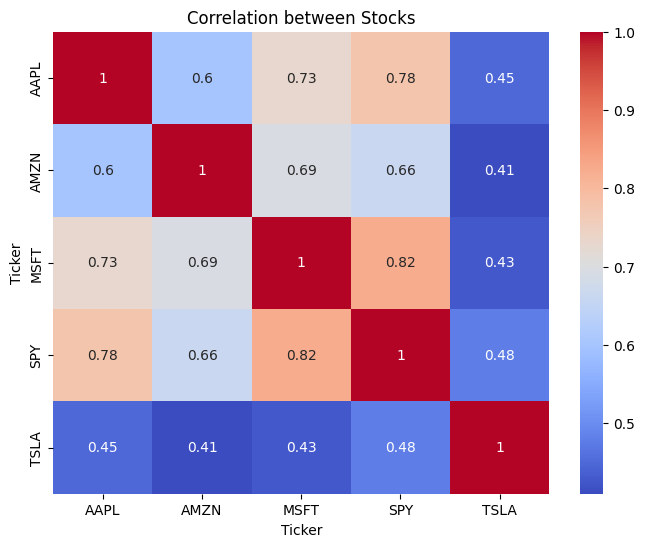

In [21]:
# Daily returns
daily_returns = adj_close.pct_change().dropna()

# Preview
print(daily_returns.head())

# Optional: visualize correlation
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Stocks")
plt.show()


Generate Realistic Target Weights (Mean-Variance Optimization)

In [22]:
def portfolio_metrics(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix*252, weights)))
    sharpe = ret / vol
    return ret, vol, sharpe

def neg_sharpe(weights, mean_returns, cov_matrix):
    return -portfolio_metrics(weights, mean_returns, cov_matrix)[2]

# Inputs for optimization
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()
num_stocks = len(tickers)
bounds = tuple((0,1) for _ in range(num_stocks))
constraints = {'type':'eq','fun': lambda x: np.sum(x)-1}

# Generate training targets: multiple random optimal weights
y_train = []
X_train = daily_returns.values[1:]  # remove first row due to pct_change
for _ in range(len(X_train)):
    result = minimize(neg_sharpe, np.random.random(num_stocks),
                      args=(mean_returns, cov_matrix),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    y_train.append(result.x)
y_train = np.array(y_train)


Prepare ANN

In [23]:
# Input scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

# Train-test split
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_train, test_size=0.2, random_state=42
)


Build and train ANN Model

In [24]:
model = Sequential([
    Dense(64, input_dim=num_stocks, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_stocks, activation='softmax')  # weights sum to 1
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)


C:\Users\HARSHIT SHARMA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0089 - val_loss: 4.2227e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6662e-04 - val_loss: 6.1958e-05
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3689e-05 - val_loss: 3.7207e-05
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6491e-05 - val_loss: 2.6742e-05
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7684e-05 - val_loss: 2.1953e-05
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2366e-05 - val_loss: 1.8434e-05
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8444e-05 - val_loss: 1.5139e-05
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5714e-05 - val_loss: 9.4283e-06
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1787e-05 - val_loss: 8.9108e-06
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9351e-06 - val_loss: 4.8950e-06
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8347e-06 - val_loss: 

Train ANN model

Evaluate Model

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0423
Test Loss: 0.04226180166006088


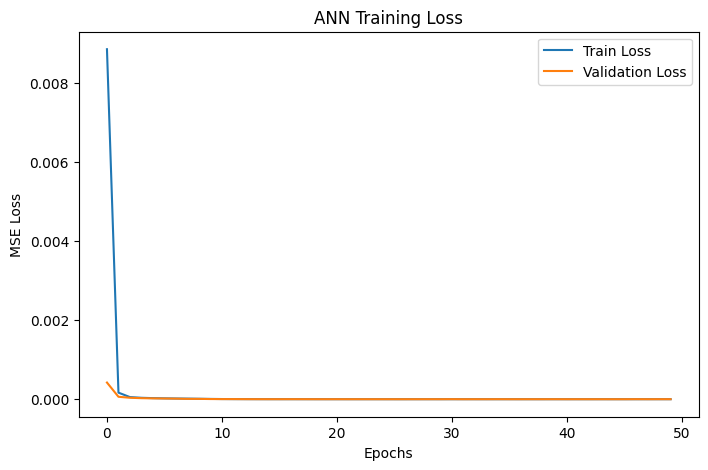

In [25]:
loss = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ANN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


predict portfolio


In [26]:
pred_weights = model.predict(X_test_scaled[-1].reshape(1,-1)).flatten()
pred_weights = pred_weights / pred_weights.sum()
portfolio = pd.DataFrame({'Stock': tickers, 'Predicted Weight': pred_weights})
print(portfolio)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
  Stock  Predicted Weight
0  AAPL          0.401379
1  MSFT          0.000159
2  AMZN          0.344719
3  TSLA          0.000162
4   SPY          0.253581


Portfolio woth an dtesting

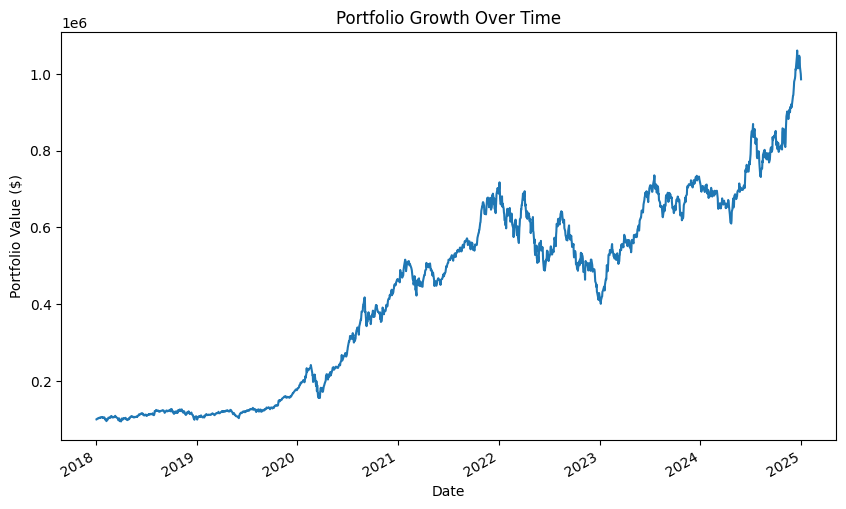

In [27]:
initial_investment = 100000
portfolio_values = (daily_returns @ pred_weights + 1).cumprod() * initial_investment

# Plot portfolio growth
plt.figure(figsize=(10,6))
portfolio_values.plot(title="Portfolio Growth Over Time")
plt.ylabel("Portfolio Value ($)")
plt.show()


portfolio risk and return

In [28]:
annual_return = np.dot(daily_returns.mean(), pred_weights) * 252
annual_vol = np.sqrt(np.dot(pred_weights.T, np.dot(daily_returns.cov()*252, pred_weights)))
sharpe_ratio = annual_return / annual_vol

print(f"Expected Annual Return: {annual_return:.2%}")
print(f"Portfolio Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Expected Annual Return: 37.82%
Portfolio Volatility: 31.68%
Sharpe Ratio: 1.19


Portfolio Predicted Weights – Bar Chart

C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_15576\818647737.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Predicted Weight', data=portfolio, palette='viridis')


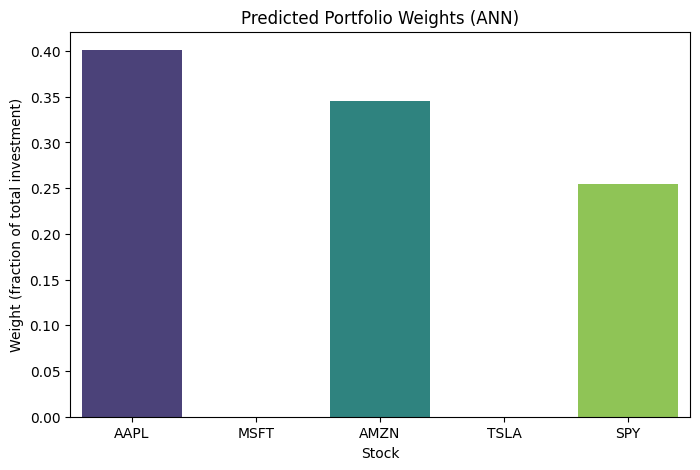

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example predicted weights
portfolio = pd.DataFrame({
    'Stock': ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'SPY'],
    'Predicted Weight': [0.401, 0.0002, 0.345, 0.0002, 0.254]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Stock', y='Predicted Weight', data=portfolio, palette='viridis')
plt.title("Predicted Portfolio Weights (ANN)")
plt.ylabel("Weight (fraction of total investment)")
plt.show()


Stock Risk (Variance / Volatility) – Bar Chart

C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_15576\1954743825.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volatility.index, y=volatility.values, palette='magma')


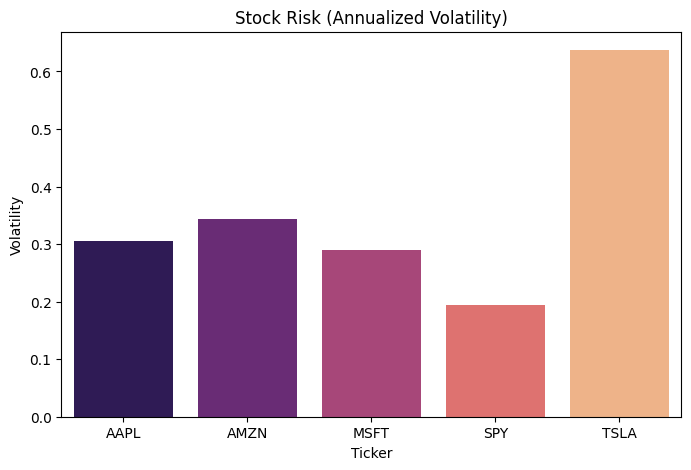

In [30]:
# Example annualized volatility from daily returns
daily_returns = adj_close.pct_change().dropna()
volatility = daily_returns.std() * (252**0.5)  # Annualized

plt.figure(figsize=(8,5))
sns.barplot(x=volatility.index, y=volatility.values, palette='magma')
plt.title("Stock Risk (Annualized Volatility)")
plt.ylabel("Volatility")
plt.show()


Portfolio Worth Over Time – Line Chart

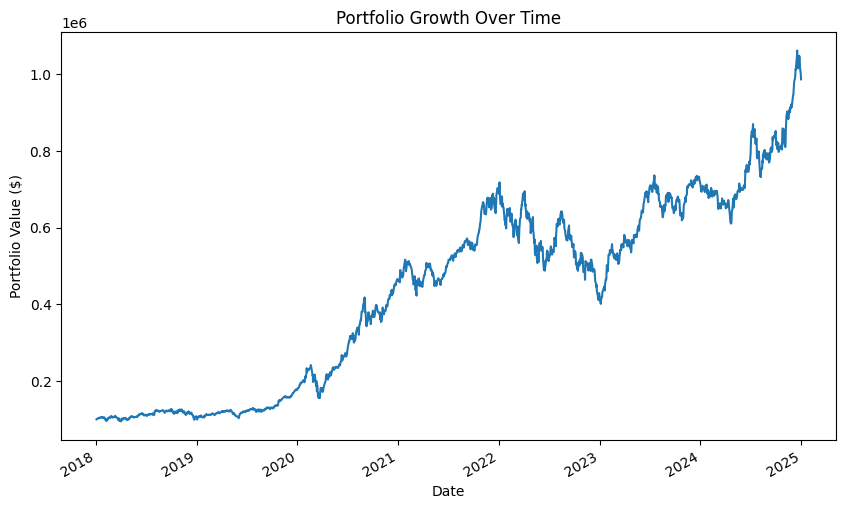

In [31]:
import numpy as np

weights = portfolio['Predicted Weight'].values
initial_investment = 100000
portfolio_values = (daily_returns @ weights + 1).cumprod() * initial_investment

plt.figure(figsize=(10,6))
portfolio_values.plot()
plt.title("Portfolio Growth Over Time")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.show()


Stock Correlation – Heatmap

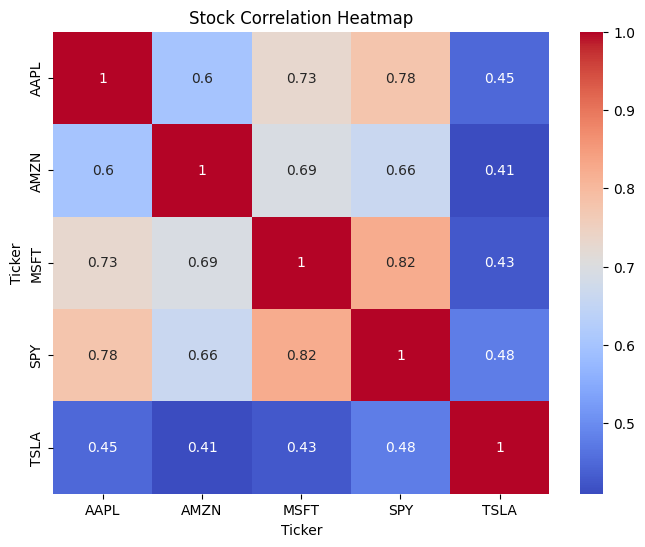

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm')
plt.title("Stock Correlation Heatmap")
plt.show()


Risk vs Weight – Scatter Plot

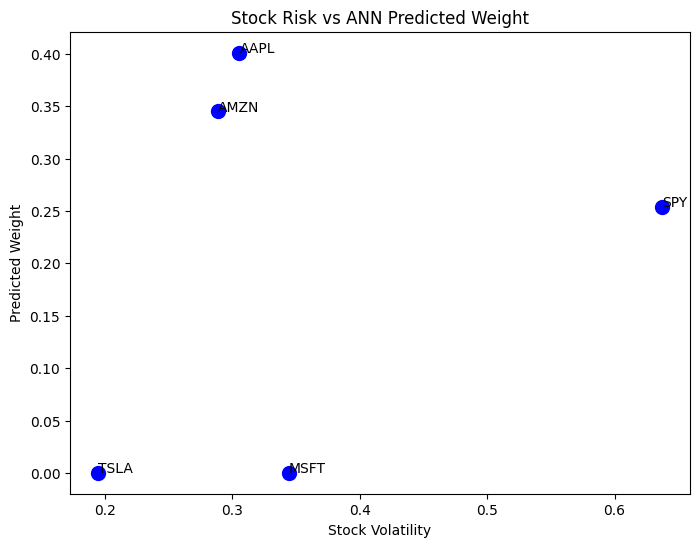

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(volatility.values, portfolio['Predicted Weight'], s=100, c='blue')
for i, txt in enumerate(portfolio['Stock']):
    plt.annotate(txt, (volatility.values[i], portfolio['Predicted Weight'][i]))
plt.xlabel("Stock Volatility")
plt.ylabel("Predicted Weight")
plt.title("Stock Risk vs ANN Predicted Weight")
plt.show()
